In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import mediapy as media
import PIL
import io

import matplotlib.patches
import seaborn as sns
from IPython.display import HTML as html_print


%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import teachers
import utils.flow_viz as flow_viz
import matplotlib

def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
    if num_objects is None:
        num_objects = np.max(seg)  # assume consecutive numbering
    num_objects += 1  # background
    if palette is None:
        palette = [bg_color] + sns.color_palette('hls', num_objects-1)

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
    for i in range(num_objects):
        seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
    return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
    cmap = np.array(colormap.colors)
    if sqrt:
        d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
    else:
        d = np.round(depth[..., 0] // 256).astype(np.uint8)
    return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

def flow_tensor_to_rgb(flow, flow_mag_range=None, white_bg=False):
    flow_ = flow.detach().cpu().permute(1,2,0).numpy()
    flow_rgb = flow_to_rgb(flow_, flow_mag_range, white_bg)
    return torch.tensor(flow_rgb).permute(2,0,1)[None]

def set_titles(titles, axes, fontsize=20):
    assert len(titles) == len(axes)
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=fontsize)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

In [4]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data as datasets
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

import mediapy as media
import PIL
import io

import matplotlib.patches

from IPython.display import HTML as html_print

## Debug new RNN with GT and base level inputs

In [165]:
T = 3

data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='validation',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
    is_test=False
)
print(len(movi_dataset))

250


In [166]:
ex = 0
data = movi_dataset[ex]
data.keys()

movie, frame b'3835' 11


dict_keys(['images', 'objects', 'flow', 'depth'])

In [161]:
for v in data.values():
    print (v.shape)

torch.Size([3, 3, 256, 256])
torch.Size([3, 1, 256, 256])
torch.Size([3, 2, 256, 256])
torch.Size([3, 1, 256, 256])


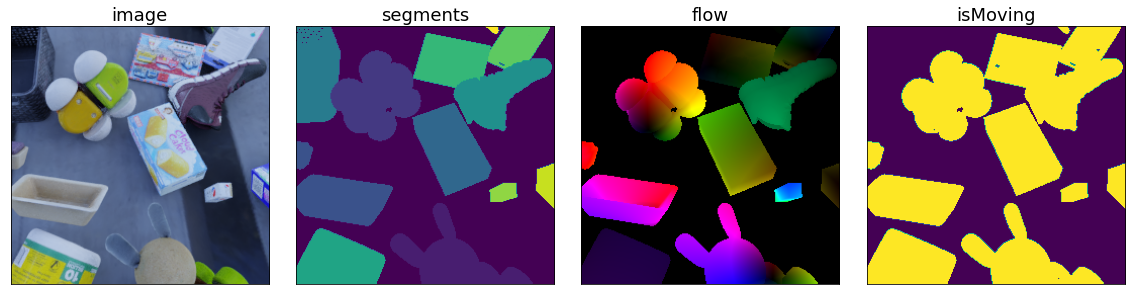

In [167]:
fig, axes = plt.subplots(1,4, figsize=(16,4))
vis_utils.imshow(data['images'], axes[0])
vis_utils.imshow(data['objects'], axes[1])
vis_utils.imshow(data['flow'].abs().sum(1, True) > 0.1, axes[3])
vis_utils.imshow(flow_tensor_to_rgb(data['flow'][0]), axes[2])

titles = ['image', 'segments', 'flow', 'isMoving']
for i,ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=18)
plt.tight_layout()
plt.show()

In [490]:
def get_gt_boot_inputs(data, t=1):
    images, objects, flow = [data[k][None].cuda() for k in ['images', 'objects', 'flow']]
    motion = (flow[:,t].abs().sum(1, True) > 0.1).float()
    boundaries = fprop.get_mask_boundaries(
        fprop.SegmentsToAffinitiesTarget.segments_to_masks(
            objects[:,t,0]))[0].amax(1, True)
    boundaries_motion = boundaries * motion
    orientations = fprop.estimate_boundary_orientations(
        boundaries=boundaries_motion,
        energy=motion,
        radius=3,
        to_circle=False
    )
    orientations = F.normalize(orientations, dim=1, p=2) * boundaries_motion
    return (motion, boundaries_motion, orientations, flow[:,t])

def viz_gt_boot_inputs(data, t=1):
    a, b, c, f = get_gt_boot_inputs(data, t=t)
    im = data['images'][t:t+1]
    fig, axes = plt.subplots(1,5,figsize=(20,4))
    
    plots = [
        im,
        a,
        b, 
        data_utils.FlowToRgb(1.0)(c),
        flow_tensor_to_rgb(f[0])
    ]
    titles = ['image', 'motion', 'boundaries', 'orientations', 'flow']
    for i,ax in enumerate(axes):
        vis_utils.imshow(plots[i], ax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=18)
        
    plt.tight_layout()
    plt.show()
    return (im, a, b, c, f)


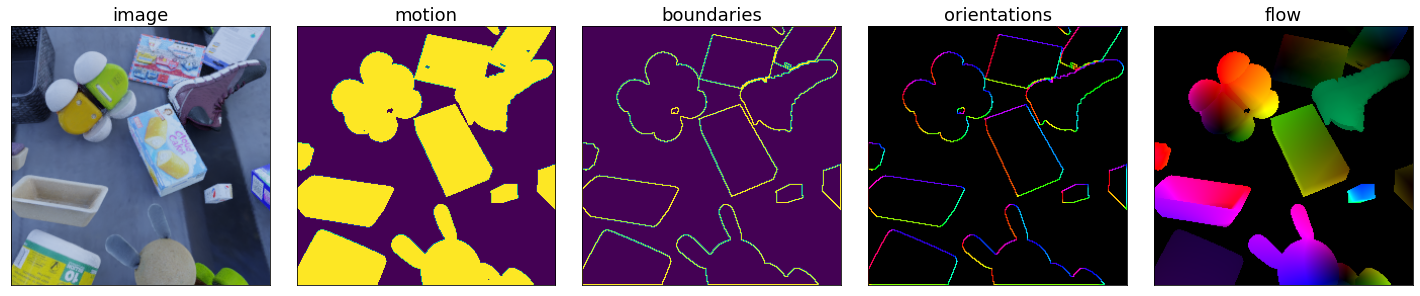

In [491]:
im, a, b, c, f = viz_gt_boot_inputs(data)

In [115]:
toponet = fprop.TopoNet(
    num_iters=10,
    diffusion_steps=250,
    beta=10.0,
    boundary_radius=3,
    boundary_thresh=None,
    boundary_cone_thresh=2.0,
    store_from=0,
    store_every=1,
    num_sample_points=2**14,
    negative_flux=True,
    boundary_flux=True,
    innate_motion_params={'warp_radius': 3, 'patch_radius': 2}
).cuda()

In [116]:
a_mask = (torch.rand(a.shape).to(a.device) > 0.0).float()
a0 = a*a_mask
b0 = b*a_mask
# b0 = b
c0 = c*a_mask
f0 = None
a_out, b_out, c_out, f_out = toponet(
    video=data['images'][None].cuda(),
    motion=None, 
    boundaries=None, 
    orientations=None,
    flow=f0
)

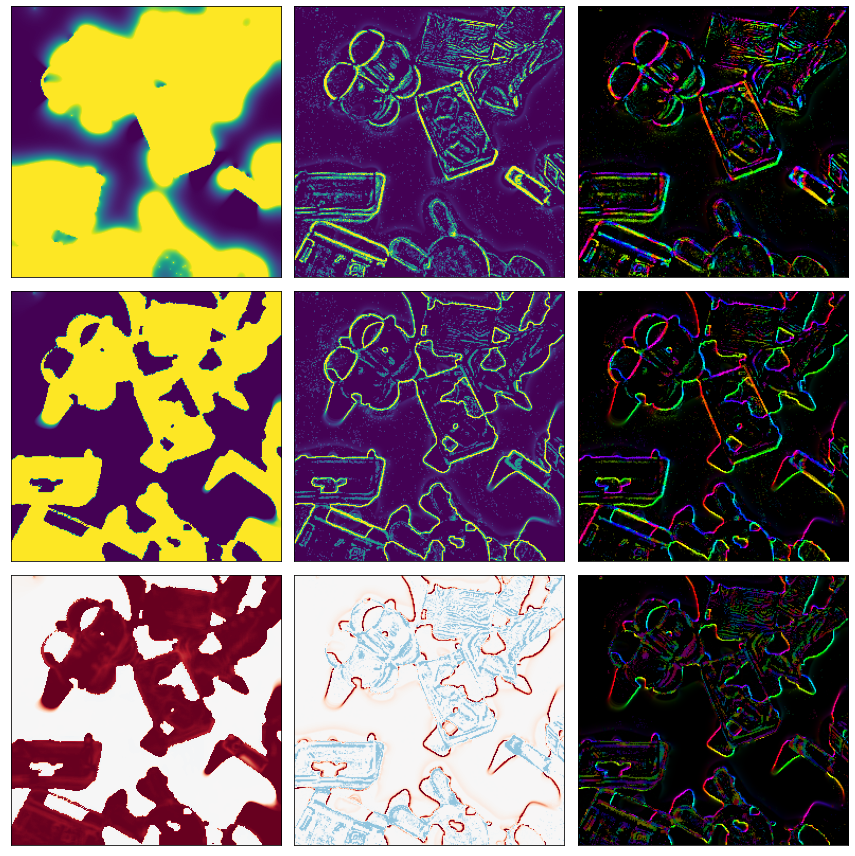

In [117]:
s = 1

fig, axes = plt.subplots(3,3,figsize=(12,12))
vis_utils.imshow(toponet.hidden_states['motion'][s], axes[0,0])
vis_utils.imshow(toponet.hidden_states['boundaries'][s], axes[0,1])
vis_utils.imshow(data_utils.FlowToRgb()(toponet.hidden_states['orientations'][s]), axes[0,2])
vis_utils.imshow(a_out, axes[1,0])
vis_utils.imshow(b_out, axes[1,1])
vis_utils.imshow(data_utils.FlowToRgb()(c_out), axes[1,2])
vis_utils.imshow(a_out - toponet.hidden_states['motion'][0], axes[2,0], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(b_out - toponet.hidden_states['boundaries'][0], axes[2,1], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb()(c_out - toponet.hidden_states['orientations'][0]), axes[2,2])

for i in range(3):
    for j in range(3):
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
plt.tight_layout()
plt.show()


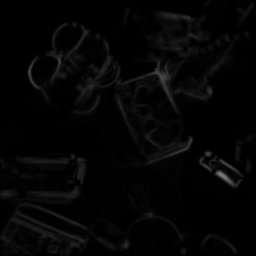
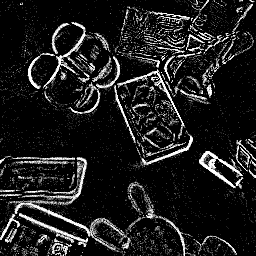
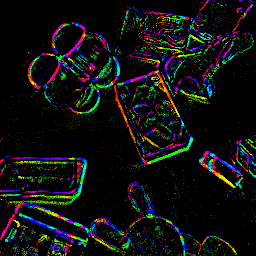

In [99]:
# media.set_show_save_dir('/home/dbear/media/toponet/')
fname = 'ex0_innate'
media.show_videos({
    "%s_motion" % fname: torch.cat(toponet.hidden_states['motion'], 0)[:,0].detach().cpu().numpy(),    
    "%s_boundaries" % fname: torch.cat(toponet.hidden_states['boundaries'], 0)[:,0].detach().cpu().numpy(),
    "%s_orientations" % fname: data_utils.FlowToRgb()(torch.cat(toponet.hidden_states['orientations'], 0)
                                          ).permute(0,2,3,1).detach().cpu().numpy()
},
    fps=4, columns=3, codec='gif'
)

In [110]:
a_mask = toponet.compute_stability_mask(
    toponet.hidden_states['motion'],
    first_state=-7,
    last_state=None,
    delta_thresh=0.0
)

b_mask = toponet.compute_stability_mask(
    toponet.hidden_states['boundaries'],
    first_state=-7,
    last_state=None,
    delta_thresh=0.0
) * a_mask

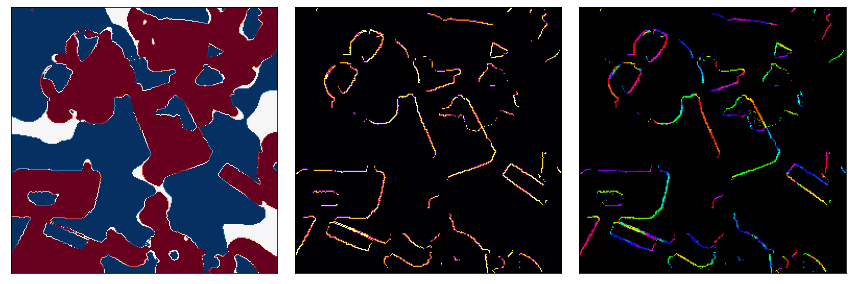

In [111]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
a_sup = 2*a_mask*a_out - a_mask
b_sup = b_mask*b_out*a_out
c_sup = data_utils.FlowToRgb()(b_mask*(b_out > 0.5).float()*c_out)

vis_utils.imshow(a_sup, axes[0], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(b_sup > 0, axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(c_sup, axes[2])

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# Debug BootRNN Training

In [171]:
!ls ../checkpoints/*topo*0acomp*bs4*rnd2*

../checkpoints/10000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_boundaries.pth
../checkpoints/10000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_motion.pth
../checkpoints/10000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_orientations.pth
../checkpoints/10000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0.pth
../checkpoints/12500_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_boundaries.pth
../checkpoints/12500_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_motion.pth
../checkpoints/12500_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_orientations.pth
../checkpoints/12500_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0.pth
../checkpoints/15000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_boundaries.pth
../checkpoints/15000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_motion.pth
../checkpoints/15000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_orientations.pth
../checkpoints/15000_topobo

In [172]:
teacher_config = {
    'motion': {
        'load_path': '../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_motion.pth'        
    },
    'boundaries': {
        'load_path': '../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_boundaries.pth'
    },
    'orientations': {
        'load_path': '../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_orientations.pth'        
    }
}

rnn_config = {
    'num_iters': 20,
    'diffusion_steps': 100,
    'boundary_thresh': None,
    'boundary_cone_thresh': 2.0,
    'negative_flux': True,
    'positive_flux': True,
    'boundary_flux': True,
    'beta': 1.0
}

target_config = {
    'first_state': -7
}

bootrnn = teachers.BootRNN(
    teacher_config=teacher_config, 
    student_config=teacher_config,
#     teacher_config='../configs/topobootrnn-0acomp-movi_d-0.yml',
#     student_config='../configs/topobootrnn-0acomp-movi_d-0.yml',
    rnn_params=rnn_config,
    target_params=target_config,
    save_dir='..',
    teach_self=False)
bootrnn.cuda()
bootrnn.train()

print(sum([v.numel() for v in bootrnn.parameters()]))

<All keys matched successfully> MotionClassifier ../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_motion.pth
<All keys matched successfully> BoundaryClassifier ../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_boundaries.pth
<All keys matched successfully> CentroidRegressor ../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_orientations.pth
<All keys matched successfully> MotionClassifier ../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_motion.pth
<All keys matched successfully> BoundaryClassifier ../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_boundaries.pth
<All keys matched successfully> CentroidRegressor ../checkpoints/35000_topobootrnn-0acomp-beta1it20-diff250-movi_d-bs4-rnd2-0_orientations.pth
8912468


In [173]:
video = data['images'][None].cuda()
preds, targets = bootrnn(video)


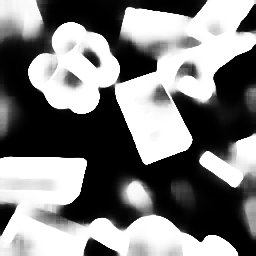
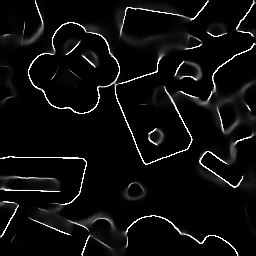
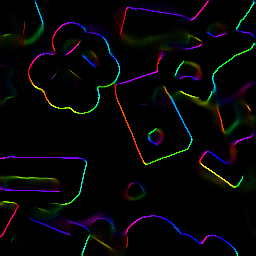

In [174]:
# media.set_show_save_dir('/home/dbear/media/toponet/')
media.set_show_save_dir(None)

fname = 'ex0_rnd0_0acomp_1beta'
media.show_videos({
    "%s_motion" % fname: torch.cat(bootrnn.boot_rnn.hidden_states['motion'], 0)[:,0].detach().cpu().numpy(),    
    "%s_boundaries" % fname: torch.cat(bootrnn.boot_rnn.hidden_states['boundaries'], 0)[:,0].detach().cpu().numpy(),
    "%s_orientations" % fname: data_utils.FlowToRgb()(torch.cat(bootrnn.boot_rnn.hidden_states['orientations'], 0)
                                          ).permute(0,2,3,1).detach().cpu().numpy()
},
    fps=4, columns=3, codec='gif'
)

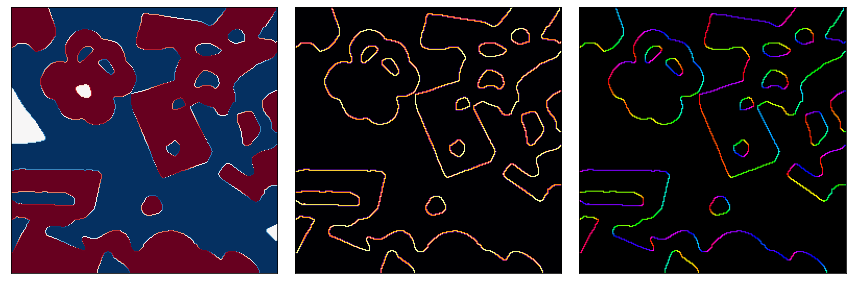

In [175]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
a_sup = 2*targets['motion'][1]*targets['motion'][0] - targets['motion'][1]
b_sup = targets['boundaries'][0]*targets['boundaries'][1]*targets['motion'][0]
c_sup = data_utils.FlowToRgb()(b_sup*targets['motion'][1]*targets['orientations'][0])

vis_utils.imshow(a_sup, axes[0], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(b_sup > 0, axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(c_sup, axes[2])

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

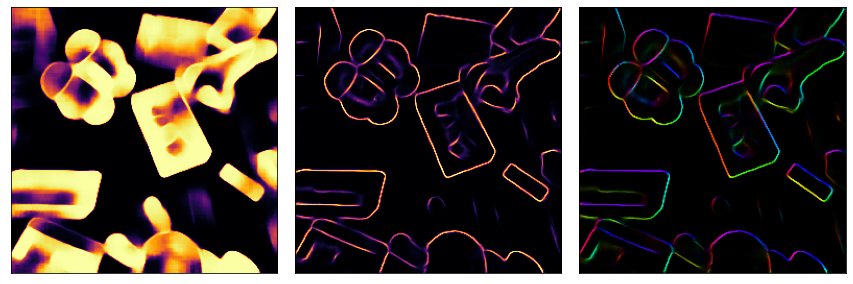

In [141]:
s = 0

fig, axes = plt.subplots(1,3, figsize=(12,4))
vis_utils.imshow(bootrnn.boot_rnn.hidden_states['motion'][s], axes[0], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(bootrnn.boot_rnn.hidden_states['boundaries'][s], axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb()(bootrnn.boot_rnn.hidden_states['orientations'][s]), axes[2])

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

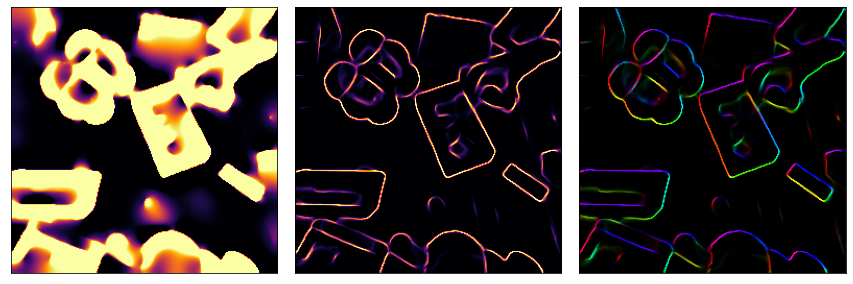

In [142]:
s = 1

fig, axes = plt.subplots(1,3, figsize=(12,4))
vis_utils.imshow(bootrnn.boot_rnn.hidden_states['motion'][s], axes[0], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(bootrnn.boot_rnn.hidden_states['boundaries'][s], axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb()(bootrnn.boot_rnn.hidden_states['orientations'][s]), axes[2])

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

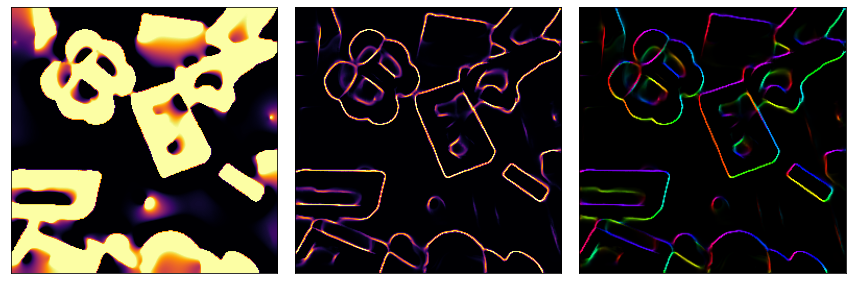

In [143]:
s = 2

fig, axes = plt.subplots(1,3, figsize=(12,4))
vis_utils.imshow(bootrnn.boot_rnn.hidden_states['motion'][s], axes[0], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(bootrnn.boot_rnn.hidden_states['boundaries'][s], axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb()(bootrnn.boot_rnn.hidden_states['orientations'][s]), axes[2])

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
vis_utils.imshow(bootrnn.boot_rnn.hidden_states['orientations'][0], cmap='inferno', vmin=0, vmax=1)

# start to build devonet

In [293]:
import dorsalventral.models.targets as targets
import dorsalventral.models.bbnet.innate as innate
import dorsalventral.models.bbnet.utils as butils

T = 5
ex = 0
data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='validation',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
    is_test=False
)
print(len(movi_dataset))

for i in range(ex):
    _ = movi_dataset[i]
data = movi_dataset[ex]
video = data['images'][None] / 255.
print(video.shape)

250
torch.Size([1, 5, 3, 256, 256])


In [285]:
IMT = innate.InnateMotionTarget(
    patch_radius=1,
    warp_radius=3,
    num_samples=16,
    sample_density=None,
    error_func=innate.utils.ChannelMSE(dim=2),
    confidence_thresh=0.75,
    probs_per_frame=True,
    use_negative_samples=False
).cuda()

In [286]:
target, loss_mask = IMT(video)


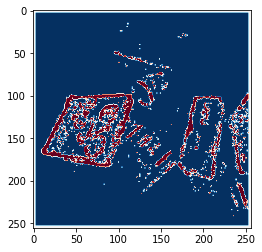

In [287]:
vis_utils.imshow(2*target - loss_mask, cmap='RdBu_r', vmin=-1, vmax=1)

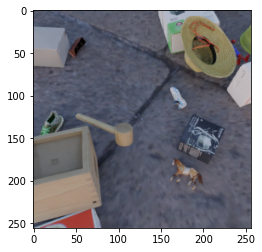

In [20]:
vis_utils.imshow(video[:,1])

In [352]:
motion_ckpts = !ls ../checkpoints/100000*bbnet*innate*motion*

for i,ckpt in enumerate(motion_ckpts):
    print(i, ckpt)

0 ../checkpoints/100000_bbnet_innate_motion_bs4_1.pth


In [358]:
anet = teachers.load_model('../checkpoints/100000_bbnet_iMotion_1gate_cthr075_0.pth', 
                            model_class='motion', 
                            small=True,
                            gate_stride=1
                           ).cuda()

<All keys matched successfully> MotionClassifier ../checkpoints/100000_bbnet_iMotion_1gate_cthr075_0.pth


In [448]:
innate_ckpts = !ls ../checkpoints/*bbnet*rnd1*_cthr*[0].pth

for i,ckpt in enumerate(innate_ckpts):
    print(i, ckpt)

0 ../checkpoints/10000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
1 ../checkpoints/10000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
2 ../checkpoints/10000_bbnet_rnd1Motion_laaS_large_seq5_cthr075_0.pth
3 ../checkpoints/1000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
4 ../checkpoints/1000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
5 ../checkpoints/1000_bbnet_rnd1Motion_laaS_large_seq5_cthr075_0.pth
6 ../checkpoints/11000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
7 ../checkpoints/11000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
8 ../checkpoints/11000_bbnet_rnd1Motion_laaS_large_seq5_cthr075_0.pth
9 ../checkpoints/12000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
10 ../checkpoints/12000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
11 ../checkpoints/12000_bbnet_rnd1Motion_laaS_large_seq5_cthr075_0.pth
12 ../checkpoints/13000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
13 ../checkpoints/13000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
14 ../checkpoints/13000_

In [449]:
imnet = teachers.load_model(innate_ckpts[130], 
                            model_class='motion', 
                            small=True,
                            gate_stride=1
                           ).cuda()

<All keys matched successfully> MotionClassifier ../checkpoints/53000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth


In [450]:
# data = movi_dataset[ex]
# video = data['images'][None] / 255.
img1, img2 = [x[None].cuda().float() for x in data['images'][1:3]]

In [451]:
_, pred1 = imnet(img1, img2, test_mode=True, iters=24)
_, pred2 = anet(img1, img2, test_mode=True, iters=24)

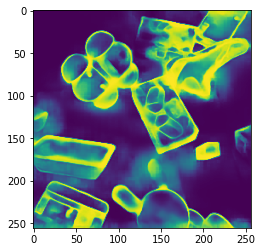

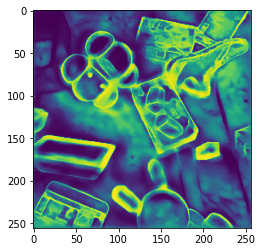

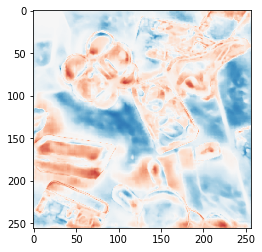

In [452]:
vis_utils.imshow(pred1.sigmoid())
vis_utils.imshow(pred2.sigmoid())
vis_utils.imshow(pred1.sigmoid() - pred2.sigmoid(), cmap='RdBu_r', vmin=-1, vmax=1)

dict_keys(['motion_target', 'source_latent', 'loss_mask'])


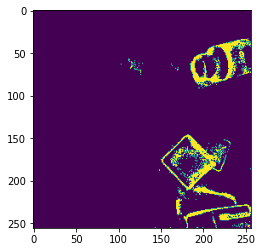

In [407]:
saved_tensors = torch.load('../checkpoints/motion_targets.pt')
print(saved_tensors.keys())


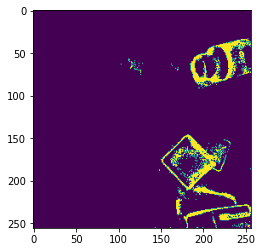

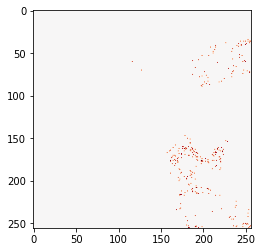

In [410]:
vis_utils.imshow(saved_tensors['source_latent'])
vis_utils.imshow(saved_tensors['motion_target'] - saved_tensors['source_latent'],
                 cmap='RdBu_r', vmin=-1, vmax=1
                )

## Saccade-based bootup

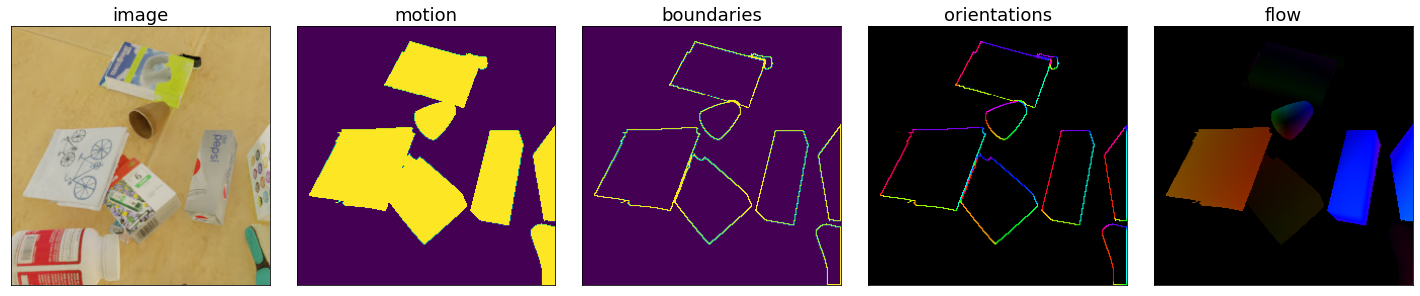

In [900]:
im, a, b, c, f = viz_gt_boot_inputs(data)

# train on movi

In [22]:
import dorsalventral.models.bbnet.innate as innate
import dorsalventral.models.bbnet.utils as butils
import dorsalventral.models.layers as layers

T = 5
B = 4
ex = 1
data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='validation',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
#     min_start_frame=0,
#     max_start_frame=None,
    is_test=False,
)
print(len(movi_dataset))
movi_loader = torch.utils.data.DataLoader(movi_dataset, batch_size=B, shuffle=True)


250


In [79]:
print_every = 25
num_steps = 10000
lr= 4e-4
wd = 1e-4

def sequence_loss(logits_list, labels, valid, gamma=0.8, loss_fn=nn.BCEWithLogitsLoss(reduction='none')):
    n_preds = len(logits_list)
    num_px = valid.sum((-2,-1)).clamp(min=1)

    loss = 0.0
    for i in range(n_preds):
        i_weight = gamma ** (n_preds - i - 1)
        i_loss = loss_fn(logits_list[i], labels) * valid
        i_loss = i_loss.sum((-2,-1)) / num_px
        i_loss = i_loss.mean() * i_weight
        loss += i_loss
    return loss

# net_encoder = layers.ResNetBasicBlock(in_dim=3, out_dim=64, stride=1, kernel_size=7, norm_fn='instance')
# net_decoder = nn.Conv2d(64, 1, kernel_size=1)
# net = nn.Sequential(net_encoder, net_decoder).cuda()

# net_kwargs = {}

bnet = teachers.load_model(load_path=None, model_class='gate', 
                          small=True, 
                          gate_stride=1,
                          out_channels=32
                         ).cuda()
bnet_kwargs = {'iters': 12, 'test_mode': False, 'get_features': False}

opt = torch.optim.AdamW(bnet.parameters(), lr=lr, weight_decay=wd, eps=1e-8)
# opt = torch.optim.AdamW(list(net_encoder.parameters()) + list(net_decoder.parameters()),
#                        lr=lr, weight_decay=wd)

target_fn = innate.InnateMotionConfidenceTarget(
    patch_radius=1,
    warp_radius=1,
    sample_density=None,
    num_samples=16,
    confidence_thresh=0.75,
    temporal_thresh=0
).cuda()

loss_fn = nn.BCEWithLogitsLoss(reduction='none')

loss_curve = []
for step in range(num_steps):
    opt.zero_grad()

    try:
        data = iter(movi_loader).next()
    except StopIteration:
        movi_loader.dataset.reset_iterator()
        data = iter(movi_loader).next()
    except Exception as e:
        print("skip", step)
        continue
        
#     x = data['images'].cuda().float() / 255.0
    x = data['images'].cuda()
    base_frame = (x.shape[1] - 1) // 2
    
    target, loss_mask = target_fn(x, frame=base_frame, loss_mask=None)
    logits_list = bnet(x[:,base_frame].float(), **bnet_kwargs)
    loss = sequence_loss(logits_list, target, loss_mask, gamma=0.8)
    loss.backward()
    
    opt.step()
    
    loss_curve.append(loss.item())
    if ((step + 1) % print_every) == 0:
        print(step+1, sum(loss_curve[-print_every:]) / print_every)

created a new GateClassifier with 1556131 parameters
25 3.1379481410980223
50 2.4202018070220945
75 2.288102560043335
100 2.1739317083358767
125 1.9117747449874878
150 1.8410044765472413
175 1.8216954612731933
200 1.8425638341903687
225 1.8927256560325623
250 1.726012077331543
275 1.8015561199188233
300 1.7756276035308838
325 1.7020187830924989
350 1.7394290637969971
375 1.7293360948562622
400 1.696873664855957
425 1.5831407594680786
450 1.8013874125480651
475 1.509820601940155
500 1.7814939308166504
525 1.7192503356933593
550 1.605251920223236
575 1.5174867367744447
600 1.8000612831115723
625 1.6799399113655091
650 1.6402422904968261
675 1.6784616804122925
700 1.3731341814994813
725 1.6897712469100952
750 1.6400700664520265
775 1.5332006883621216
800 1.7382170629501343
825 1.6422327041625977
850 1.5064859223365783
875 1.6270251536369325
900 1.3502597117424011
925 1.3662425255775452
950 1.490876693725586
975 1.482731866836548
1000 1.6170301151275634
1025 1.4775520634651185
1050 1.37009

KeyboardInterrupt: 

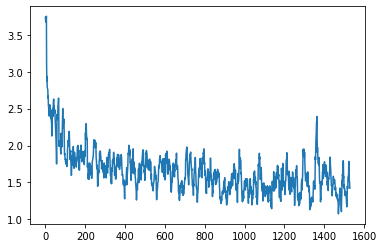

In [80]:
plt.plot(np.convolve(np.array(loss_curve), 0.1 * np.ones([10]))[10:-10])

In [23]:
bnet_path = '../checkpoints/10000_bbnet_iConvGate_cthr095_bs16_0.pth'
bnet = teachers.load_model(load_path=bnet_path, 
                           model_class='conv', 
                           small=True, 
                           gate_stride=1,
#                            out_channels=32
                           out_channels=64
).cuda()
bnet.train()
bnet_kwargs = {'iters': 24, 'test_mode': True, 'get_features': False}

target_fn = innate.InnateMotionConfidenceTarget(
    patch_radius=1,
    warp_radius=1,
    sample_density=None,
    num_samples=16,
    confidence_thresh=0.95,
    temporal_thresh=0
).cuda()

<All keys matched successfully> ConvClassifier ../checkpoints/10000_bbnet_iConvGate_cthr095_bs16_0.pth


In [32]:
x = movi_dataset[0]['images'][None].cuda()
# net = nn.Sequential(net_encoder, net_decoder).cuda()

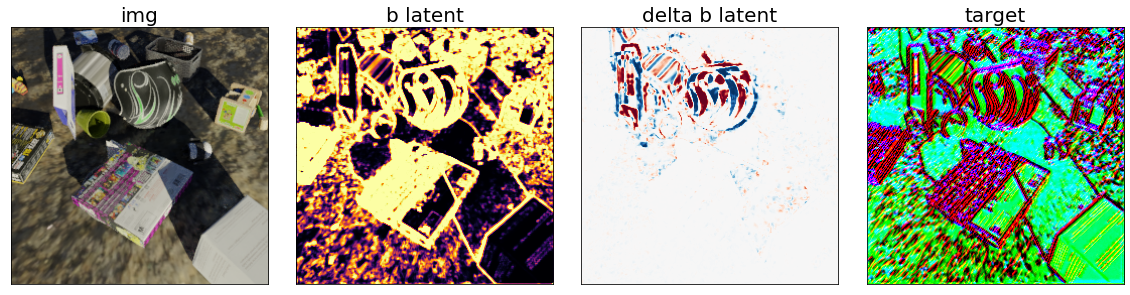

In [33]:
fig, axes = plt.subplots(1,4,figsize=(16,4))
cs = [0,3]
base_frame = 2

img = x.float() / 255.
y0 = bnet(img[:,base_frame-1], test_mode=True, iters=24)[-1].sigmoid()
y1 = bnet(img[:,base_frame], test_mode=True, iters=24)[-1].sigmoid()
y2 = bnet(img[:,base_frame+1], test_mode=True, iters=24)[-1].sigmoid()
conf_moving = y1 - y2
z = bnet(img[:,base_frame], get_features=True, test_mode=True)[-1]

# a = anet(img[:,base_frame], img[:,base_frame+1], test_mode=True, iters=24)[-1].sigmoid()
# target, loss_mask = target_fn(x, loss_mask=a)

vis_utils.imshow(x[:,base_frame], axes[0])
vis_utils.imshow(y1, axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(conf_moving, axes[2], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(z[:,cs[0]:cs[1]], axes[3])
# vis_utils.imshow(target*loss_mask*2 - loss_mask, axes[3], cmap='RdBu_r', vmin=-1, vmax=1)

titles = ['img', 'b latent', 'delta b latent', 'target']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()

In [208]:
print((y1 > 0.5).sum() / y1.numel())

tensor(0.3925, device='cuda:0')


In [188]:
from torch.distributions.bernoulli import Bernoulli
y_dist = Bernoulli(probs=y1)

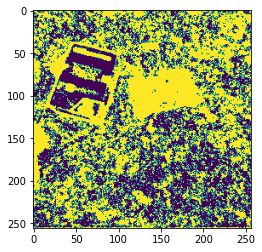

In [190]:
y_sample = y_dist.sample()
vis_utils.imshow(y_sample)

In [191]:
torch.unique(y_sample)

tensor([0., 1.], device='cuda:0')

In [406]:
# SAVE_PATH = '../checkpoints/25000_innateMC_cthr075_tthr1_bs4_0.pth'
# did_save = torch.save(net.state_dict(), SAVE_PATH)
# print(did_save)

None


## Now use b latent to train a latent (motion)

In [34]:
import dorsalventral.models.bbnet.innate as innate
import dorsalventral.models.bbnet.utils as butils
import dorsalventral.models.layers as layers

T = 5
B = 4
ex = 1
data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='train',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
#     min_start_frame=12-(T//2),
#     max_start_frame=12-(T//2),
    min_start_frame=0,
    max_start_frame=None,
    is_test=False,
)
print(len(movi_dataset))
movi_loader = torch.utils.data.DataLoader(movi_dataset, batch_size=B, shuffle=True)


IM = innate.InnateMotionTarget(
    warp_radius=5,
    patch_radius=1,
    num_samples=16,
    sample_density=None,
    confidence_thresh=0.75
).cuda()


LOAD_PATH = '../checkpoints/25000_innateMC_cthr075_tthr1_bs4_0.pth'
bnet_encoder = layers.ResNetBasicBlock(in_dim=3, out_dim=64, stride=1, kernel_size=7, norm_fn='instance')
bnet_decoder = nn.Conv2d(64, 1, kernel_size=1)
bnet = nn.Sequential(bnet_encoder, bnet_decoder).cuda()
did_load = bnet.load_state_dict(torch.load(LOAD_PATH))
print(did_load)

9750
<All keys matched successfully>


In [35]:
x = movi_dataset[0]['images'][None].cuda()
a_target, a_mask  = IM(x, frame=None, loss_mask=None)

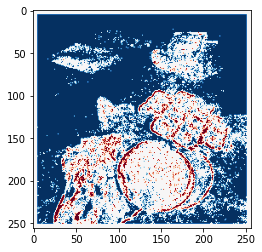

In [36]:
vis_utils.imshow(a_target*a_mask*2 - a_mask, cmap='RdBu_r', vmin=-1, vmax=1)

In [37]:
print_every = 1
num_steps = 10
lr= 4e-4
wd = 1e-4
gate_loss = True
gate_thresh = 0.5

def sequence_loss(logits_list, labels, valid, gamma=0.8, loss_fn=nn.BCEWithLogitsLoss(reduction='none')):
    n_preds = len(logits_list)
    num_px = valid.sum((-2,-1)).clamp(min=1)

    loss = 0.0
    for i in range(n_preds):
        i_weight = gamma ** (n_preds - i - 1)
        i_loss = loss_fn(logits_list[i], labels) * valid
        i_loss = i_loss.sum((-2,-1)) / num_px
        i_loss = i_loss.mean() * i_weight
        loss += i_loss
    return loss

anet = teachers.load_model(load_path=None, model_class='motion', 
                          small=True, 
                          gate_stride=1
                         ).cuda()
anet_kwargs = {'iters': 12, 'test_mode': False}

opt = torch.optim.AdamW(anet.parameters(),
                       lr=lr, weight_decay=wd, eps=1e-8)

target_fn = innate.InnateMotionTarget(
    warp_radius=5,
    patch_radius=1,
    num_samples=16,
    sample_density=None,
    confidence_thresh=0.75
).cuda()

def mask_fn(net, video, frame, thresh=0.5):
    mask = net(video[:,frame].float() / 255.).sigmoid().detach()
    if thresh is not None:
        mask = (mask > thresh).float()
    return mask

loss_curve = []
for step in range(num_steps):
    opt.zero_grad()

    try:
        data = iter(movi_loader).next()
    except StopIteration:
        movi_loader.dataset.reset_iterator()
        data = iter(movi_loader).next()
    except Exception as e:
        print("skip", step)
        continue
        
    x = data['images'].cuda()
    base_frame = (x.shape[1] - 1) // 2
    
    logits_list = anet(x[:,base_frame].float(), x[:,base_frame+1].float(), **anet_kwargs)
    loss_gate = mask_fn(bnet, x, base_frame, gate_thresh) if gate_loss else None
    target, loss_mask, errors_s, errors_m = target_fn(x, frame=base_frame, loss_mask=loss_gate)

    loss = sequence_loss(logits_list, target, loss_mask, gamma=0.8, loss_fn=nn.BCEWithLogitsLoss(reduction='none'))
    loss.backward()
    
    opt.step()
    
    loss_curve.append(loss.item())
    if ((step + 1) % print_every) == 0:
        print(step+1, sum(loss_curve[-print_every:]) / print_every)


TypeError: super(type, obj): obj must be an instance or subtype of type

In [627]:
apath = '../checkpoints/100000_bbnet_iMotion_1gate_cthr075_0.pth'
anet = teachers.load_model(
    load_path=apath,
    model_class='motion',
    small=True,
    gate_stride=1
).cuda()

target_fn = innate.InnateMotionTarget(
    warp_radius=5,
    patch_radius=1,
    num_samples=16,
    sample_density=None,
    confidence_thresh=0.75
).cuda()

T = 5
B = 4
ex = 1
data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='validation',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
#     min_start_frame=0,
#     max_start_frame=None,
    is_test=False,
)
print(len(movi_dataset))

<All keys matched successfully> MotionClassifier ../checkpoints/100000_bbnet_iMotion_1gate_cthr075_0.pth
250


In [898]:
data = movi_dataset[0]
x = data['images'][None].cuda()
flow = data['flow'][None].cuda()

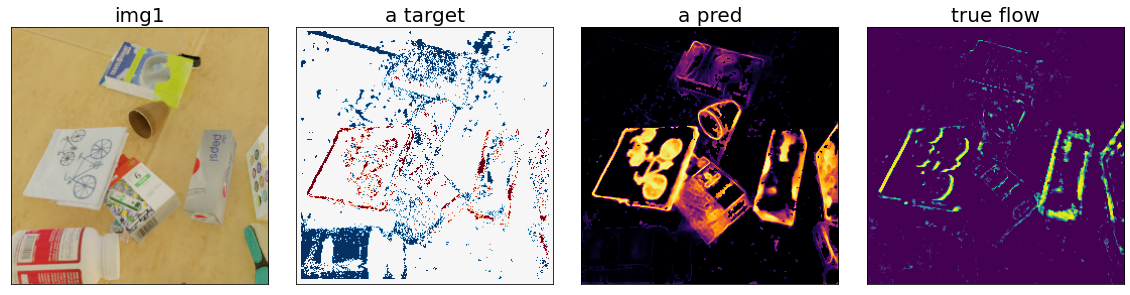

In [899]:
do_gate = True
base_frame = 2

a = anet(x[:,base_frame].float(), x[:,base_frame+1].float(), iters=24, test_mode=True)[-1]
b = bnet(x[:,base_frame].float(), iters=12, test_mode=True)[-1]
b_rev = bnet(x[:,base_frame+1].float(), iters=12, test_mode=True)[-1]
gate = (b.sigmoid() > 0.5).float() if do_gate else None
target, loss_mask = target_fn(x, loss_mask=gate)

fig, axes = plt.subplots(1,4,figsize=(16,4))
vis_utils.imshow(x[:,base_frame], axes[0])
vis_utils.imshow(target*loss_mask*2 - loss_mask, axes[1], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(a.sigmoid()*gate, axes[2], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(F.relu(b.sigmoid() - b_rev.sigmoid())*gate, axes[3], cmap='viridis', vmin=0, vmax=1)
# vis_utils.imshow(data_utils.FlowToRgb(5)(flow[:,base_frame]), axes[3])

titles = ['img1', 'a target', 'a pred', 'true flow']
set_titles(titles, axes)
plt.show()
    

In [421]:
# SAVE_PATH = '../checkpoints/2500_innateM_0gate_cthr075_bs4_0.pth'
# SAVE_PATH = '../checkpoints/2500_innateM_1gate_cthr075_bs4_0.pth'
# torch.save(anet.state_dict(), SAVE_PATH)

In [630]:
toponet = fprop.TopoNet(
    num_iters=20,
    diffusion_steps=250,
    beta=10.0,
    boundary_radius=3,
    boundary_thresh=None,
    boundary_cone_thresh=2.0,
    store_from=0,
    store_every=1,
    num_sample_points=2**14,
    negative_flux=True,
    boundary_flux=True,
    innate_motion_params={'warp_radius': 3, 'patch_radius': 2}
).cuda()

In [900]:
a_in = a.sigmoid()
# b_in = F.relu(b.sigmoid() - b_rev.sigmoid())
b_in = kornia.filters.sobel(a_in)

a_out, b_out, c_out, f_out = toponet(
    video=data['images'][None].cuda()[:,1:-1],
    motion=a_in, 
    boundaries=b_in, 
    orientations=None,
    flow=None
)


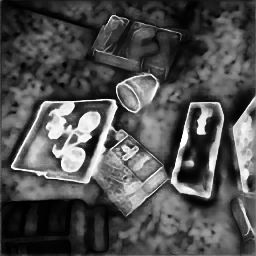
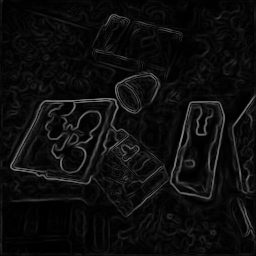
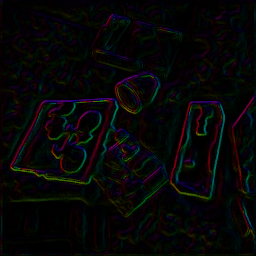

In [901]:
# media.set_show_save_dir('/home/dbear/media/toponet/')
fname = 'ex0_innate'
media.show_videos({
    "%s_motion" % fname: torch.cat(toponet.hidden_states['motion'], 0)[:,0].detach().cpu().numpy(),    
    "%s_boundaries" % fname: torch.cat(toponet.hidden_states['boundaries'], 0)[:,0].detach().cpu().numpy(),
    "%s_orientations" % fname: data_utils.FlowToRgb()(torch.cat(toponet.hidden_states['orientations'], 0)
                                          ).permute(0,2,3,1).detach().cpu().numpy()
},
    fps=4, columns=3, codec='gif'
)

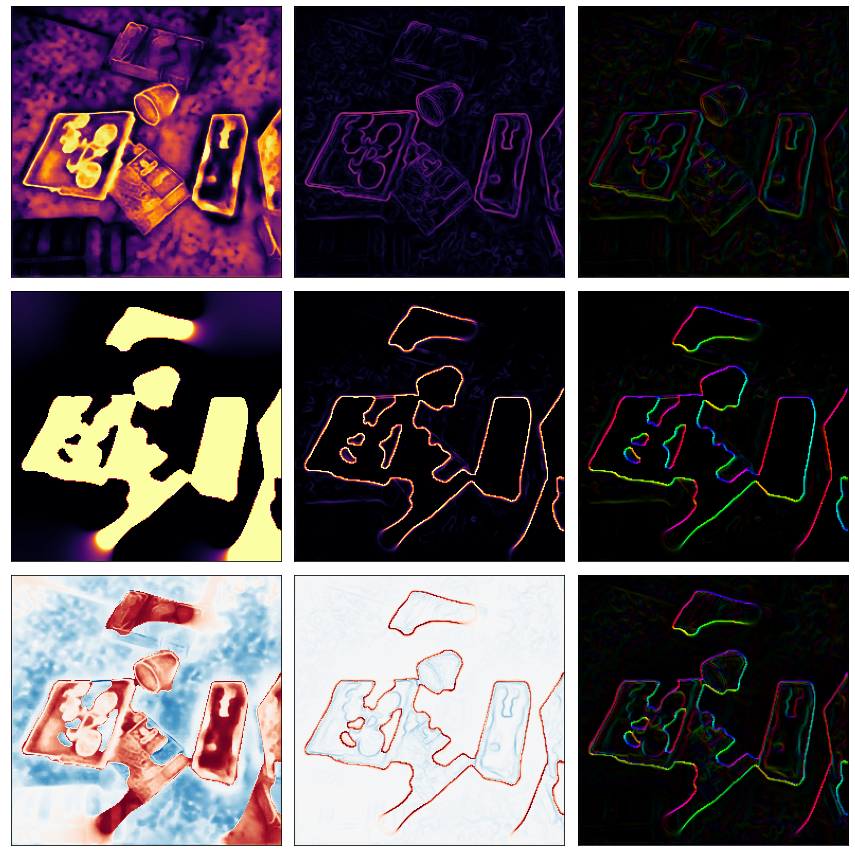

In [902]:
s = 0

fig, axes = plt.subplots(3,3,figsize=(12,12))
vis_utils.imshow(toponet.hidden_states['motion'][s], axes[0,0], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(toponet.hidden_states['boundaries'][s], axes[0,1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb()(toponet.hidden_states['orientations'][s]), axes[0,2])
vis_utils.imshow(a_out, axes[1,0], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(b_out, axes[1,1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb()(c_out), axes[1,2])
vis_utils.imshow(a_out - toponet.hidden_states['motion'][0], axes[2,0], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(b_out - toponet.hidden_states['boundaries'][0], axes[2,1], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb()(c_out - toponet.hidden_states['orientations'][0]), axes[2,2])

for i in range(3):
    for j in range(3):
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
plt.tight_layout()
plt.show()

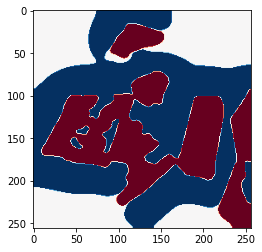

In [903]:
a_target, a_mask = toponet.get_target_and_mask('motion', first_state=-7)
vis_utils.imshow(a_target*a_mask*2 - a_mask, cmap='RdBu_r', vmin=-1, vmax=1)

In [904]:
def get_gt_boot_inputs(data, t=1):
    images, objects, flow = [data[k][None].cuda() for k in ['images', 'objects', 'flow']]
    motion = (flow[:,t].abs().sum(1, True) > 0.1).float()
    boundaries = fprop.get_mask_boundaries(
        fprop.SegmentsToAffinitiesTarget.segments_to_masks(
            objects[:,t,0]))[0].amax(1, True)
    boundaries_motion = boundaries * motion
    orientations = fprop.estimate_boundary_orientations(
        boundaries=boundaries_motion,
        energy=motion,
        radius=3,
        to_circle=False
    )
    orientations = F.normalize(orientations, dim=1, p=2) * boundaries_motion
    return (motion, boundaries_motion, orientations, flow[:,t])

def viz_gt_boot_inputs(data, t=1):
    a, b, c, f = get_gt_boot_inputs(data, t=t)
    im = data['images'][t:t+1]
    fig, axes = plt.subplots(1,5,figsize=(20,4))
    
    plots = [
        im,
        a,
        b, 
        data_utils.FlowToRgb(1.0)(c),
        flow_tensor_to_rgb(f[0])
    ]
    titles = ['image', 'motion', 'boundaries', 'orientations', 'flow']
    for i,ax in enumerate(axes):
        vis_utils.imshow(plots[i], ax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=18)
        
    plt.tight_layout()
    plt.show()
    return (im, a, b, c, f)


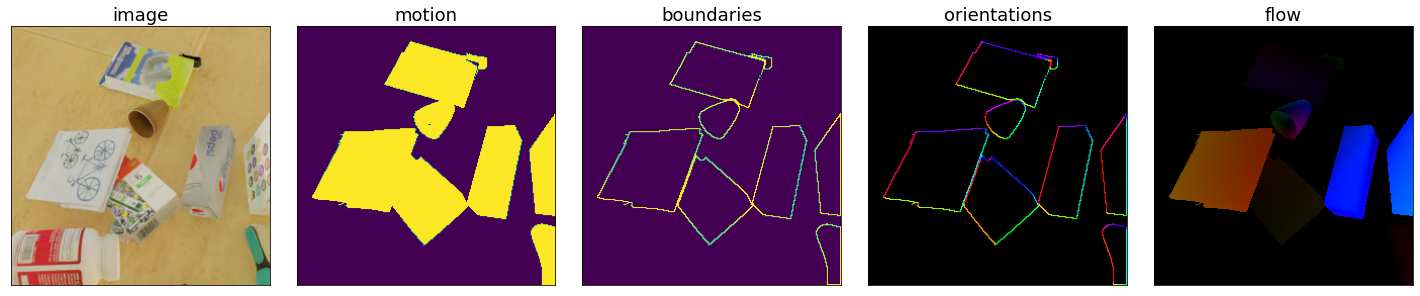

In [905]:
im, a_gt, b_gt, c_gt, f_gt = viz_gt_boot_inputs(data)

tensor(0.1338, device='cuda:0')


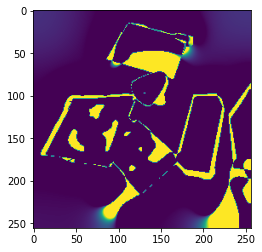

In [577]:
loss = nn.L1Loss(reduction='none')(a_out, a_gt)
print(loss.mean())
vis_utils.imshow(loss)

tensor(0.3211, device='cuda:0')


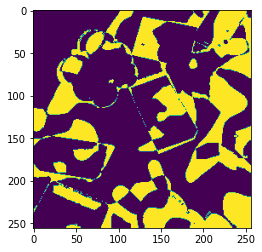

In [617]:
loss = nn.L1Loss(reduction='none')(a_target*a_mask, a_gt*a_mask)
print(loss.mean())
vis_utils.imshow(loss)

tensor(24.1981, device='cuda:0')


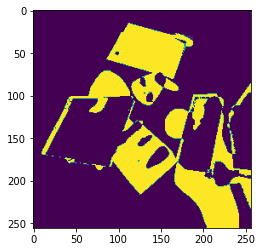

In [596]:
loss = nn.BCELoss(reduction='none')(a_out, a_gt)
print(loss.mean())
vis_utils.imshow(loss)

tensor(23.8403, device='cuda:0')


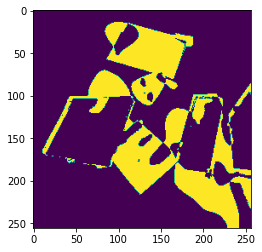

In [584]:
loss = nn.BCELoss(reduction='none')(a_target*a_mask, a_gt)
print(loss.mean())
vis_utils.imshow(loss)

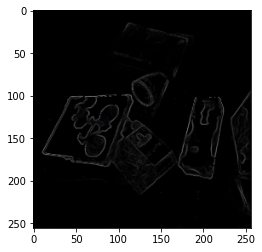

In [549]:
import kornia
b_in = torch.minimum(kornia.filters.sobel(a_in), kornia.filters.sobel(im.float().cuda())) * gate * a.sigmoid()
vis_utils.imshow(b_in)

# Learnable local message passing

In [5]:
import dorsalventral.models.bbnet.messages as messages

MSG = messages.LocalSpatialMessages(
    radius=5, 
    affinity_nonlinearity='none', 
    num_iters=100,
    store_every=None,
    mask_background=True
).cuda()

size = a_in.shape[-2:]
affs = torch.ones((1,MSG.K,*size), device=a_in.device)
affs_gt = butils.get_local_neighbors(a_gt, radius=MSG.radius, to_image=True)[:,0]
affs_gt = (affs_gt == a_gt).float()

NameError: name 'a_in' is not defined

In [911]:
mask = (torch.rand(a_gt.shape) > 0.75).float().to(a_gt.device)

y_out = MSG(
    a_in, 
    affs_gt*a_gt,
    mask=gate, 
    target_latent=None)

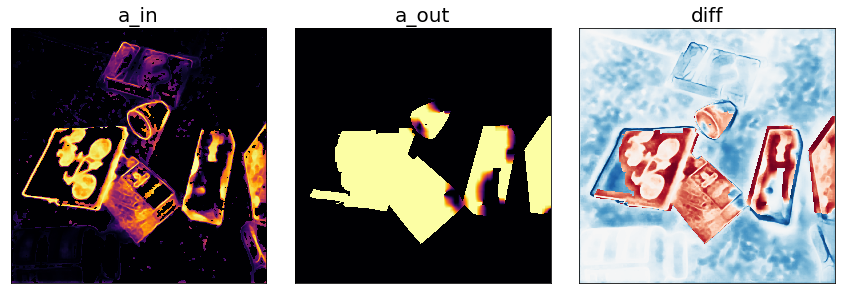

In [912]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
vis_utils.imshow(a_in*gate, axes[0], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(y_out, axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(y_out - a_in, axes[2], cmap='RdBu_r', vmin=-1, vmax=1)

titles = ['a_in', 'a_out', 'diff']
set_titles(titles, axes)
plt.show()

## trying to learn messages

In [990]:
import dorsalventral.models.bbnet.pathways as pathways

Anet = pathways.RaftVideoWrapper(net=anet, 
                                model_kwargs={'test_mode': True, 'iters':24}, 
                                nonlinearity=torch.sigmoid,
                                stop_grad=True).cuda()

PBS = pathways.PathwayBinarySampler(num_samples=4, thresh=0.75).cuda()


In [994]:
x = movi_dataset[0]['images'][None]

In [995]:
out = Anet(x.cuda())
target, loss_mask = PBS(out)

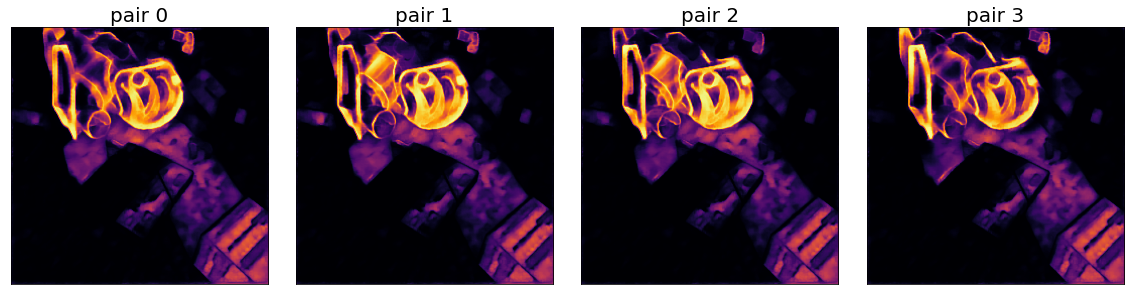

In [996]:
fig, axes = plt.subplots(1, len(out), figsize=(len(out)*4, 4))

for i, ax in enumerate(axes):
    vis_utils.imshow(out[i], ax, cmap='inferno', vmin=0, vmax=1)

titles = ['pair %d' % d for d in range(len(out))]
set_titles(titles, axes)
plt.show()

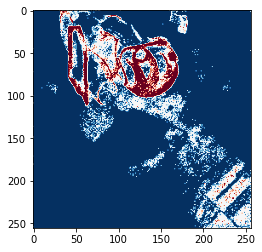

In [997]:
vis_utils.imshow(target*loss_mask*2 - loss_mask, cmap='RdBu_r', vmin=-1, vmax=1)

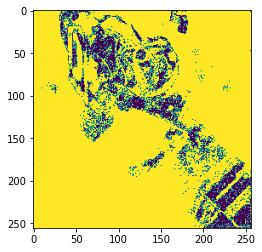

In [998]:
vis_utils.imshow(loss_mask)

In [999]:
MSG = messages.LocalSpatialMessages(
    radius=3, 
    affinity_nonlinearity='none', 
    num_iters=10,
    store_every=None,
    mask_background=True
).cuda()

In [1003]:
y_out = MSG(
    source_latent=target,
    affinities=affs_gt,
    mask=loss_mask
)

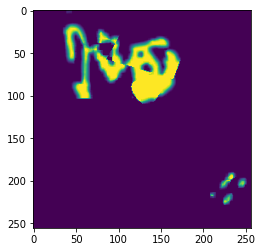

In [1004]:
vis_utils.imshow(y_out)

In [1006]:
labels, loss_gate = MSG.get_labels_and_mask(target, loss_mask, loss_mask)

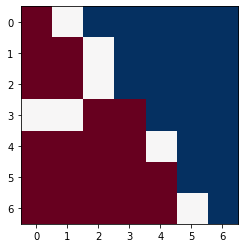

In [1025]:
px = [48,165]
_labels = labels[...,px[0],px[1]].view(1,1,7,7)
_loss_gate = loss_gate[...,px[0],px[1]].view(1,1,7,7)
vis_utils.imshow(_labels*_loss_gate*2 - _loss_gate, cmap='RdBu_r', vmin=-1, vmax=1)


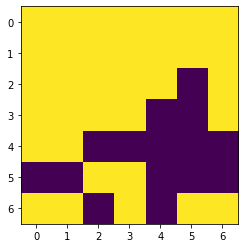

In [1013]:
vis_utils.imshow(loss_gate[0,:,98,150].view(1,1,7,7))

In [29]:
T = 5
B = 1
ex = 1
data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='train',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
#     min_start_frame=0,
#     max_start_frame=None,
    is_test=False,
)
print(len(movi_dataset))

movi_loader = torch.utils.data.DataLoader(movi_dataset, batch_size=B, shuffle=True)


9750


In [46]:
import dorsalventral.models.bbnet.pathways as pathways
import dorsalventral.models.bbnet.messages as messages
import dorsalventral.models.bbnet.utils as butils

laa_net = teachers.load_model(
    load_path=None,
    model_class='affinity',
    affinity_radius=3,
    small=True,
    gate_stride=1,
    affinity_nonlinearity='none'
).cuda()

LAA_net = pathways.RaftPerFrameWrapper(
    net=laa_net,
    model_kwargs={'test_mode': False, 'iters': 12},
    nonlinearity='none',
    postproc_func=None
)

apath = '../checkpoints/100000_bbnet_iMotion_1gate_cthr075_0.pth'
anet = teachers.load_model(
    load_path=apath,
    model_class='motion',
    small=True,
    gate_stride=1
).cuda()

Anet = pathways.RaftVideoWrapper(net=anet, 
                                model_kwargs={'test_mode': True, 'iters':24}, 
                                nonlinearity='sigmoid',
                                 postproc_func=pathways.raft_postproc,
                                stop_grad=True).cuda()

PBS = pathways.PathwayBinarySampler(num_samples=4, thresh=0.75).cuda()

MSG = messages.LocalSpatialMessages(
    radius=3, 
    affinity_nonlinearity='sigmoid', 
    num_iters=10,
    store_every=None,
    mask_background=True
).cuda()


created a new SpatialAffinityDecoder with 1595283 parameters
<All keys matched successfully> MotionClassifier ../checkpoints/100000_bbnet_iMotion_1gate_cthr075_0.pth


In [47]:
x = movi_dataset[0]['images']
affs = LAA_net(x[None].cuda())
print(len(affs))

12


In [48]:
print_every = 1
num_steps = 10
lr= 4e-4
wd = 1e-4

def sequence_loss(logits_list, labels, valid, gamma=0.8, loss_fn=nn.BCEWithLogitsLoss(reduction='none')):
    n_preds = len(logits_list)
    num_px = valid.sum((-2,-1)).clamp(min=1)

    loss = 0.0
    for i in range(n_preds):
        i_weight = gamma ** (n_preds - i - 1)
        i_loss = loss_fn(logits_list[i], labels) * valid
        i_loss = i_loss.sum((-2,-1)) / num_px
        i_loss = i_loss.mean() * i_weight
        loss += i_loss
    return loss

opt = torch.optim.AdamW(LAA_net.parameters(),
                       lr=lr, weight_decay=wd, eps=1e-8)

loss_curve = []
for step in range(num_steps):
    opt.zero_grad()

    try:
        data = iter(movi_loader).next()
    except StopIteration:
        movi_loader.dataset.reset_iterator()
        data = iter(movi_loader).next()
    except Exception as e:
        print("skip", step)
        continue
        
    x = data['images'].cuda()
    base_frame = (x.shape[1] - 1) // 2
    
    affinities_list = LAA_net(x)
    a_preds = Anet(x)
    a_target, a_mask = PBS(a_preds)
    
#     print(logits_list[-1].shape)
#     print(a_preds[0].shape)
#     print(a_target.shape, torch.unique(a_target))

    a_out = MSG(
        a_target,
        affinities=affinities_list[-1],
        mask=a_mask,
    )
    
    loss = MSG.loss
    
#     logits_list = anet(x[:,base_frame].float(), x[:,base_frame+1].float(), **anet_kwargs)
#     loss_gate = mask_fn(bnet, x, base_frame, gate_thresh) if gate_loss else None
#     target, loss_mask, errors_s, errors_m = target_fn(x, frame=base_frame, loss_mask=loss_gate)

#     loss = sequence_loss(logits_list, target, loss_mask, gamma=0.8, loss_fn=nn.BCEWithLogitsLoss(reduction='none'))
    loss.backward()
    
    opt.step()
    
    loss_curve.append(loss.item())
    if ((step + 1) % print_every) == 0:
        print(step+1, sum(loss_curve[-print_every:]) / print_every)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 49, 256, 256]], which is output 0 of SigmoidBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).